In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.text import *
from fastai.column_data import *

In [2]:
# from fsm import *

In [3]:
DATA_PATH = Path('data')
DATA_PATH
TMP_PATH = DATA_PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
sql_ids = np.load(TMP_PATH/'sql_ids.npy')
sql_itos = pickle.load(open(TMP_PATH/'sql_itos.pkl','rb'))
sql_stoi =  collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(sql_itos)})

In [5]:
def test_case():
    sample = ['updat','selec','delet','inser']
    for i in sample:
        print('Input:', i, 'output:', i+get_next(i))
              
    sample = ['update','select','insert','delete']          
    for i in sample:
            print('Input:', i, 'output:', sentence(i))    

In [7]:
# fsm = Rule_Parse_FSM()

# get_next_random("select userid from users where ".split())

# get_next_random_fsm("select userid from users where ".split(), fsm)

## Setup

Set up directory path

In [40]:
dataset = pd.read_json(DATA_PATH/'train.json')
dataset.head(1)


,comments,description,id,sql,sql_plain,title,url
0,[],,586912,"SELECT p.Title,p.score,p.ViewCount,p.AnswerCou...","SELECT \np.Title,p.score,p.ViewCount,p.AnswerC...",Repent 151-160,http://data.stackexchange.com/stackoverflow/re...


In [53]:
# get_next_random("select userid from users where ".split())

SQL = dataset.sql
SQL = SQL.str.lower() # Pad space around non character string

In [57]:
SQL = SQL.str.replace('(\W)', r' \1 ')

In [59]:
SQL[:2]

0    select   p . title , p . score , p . viewcount...
1    create   table    # customerdb    (    id   in...
Name: sql, dtype: object

###  Weird Spacy

In [42]:
tmp =["id userid normal ac hed wed theyd  itd ID WED"]

In [43]:
Tokenizer.proc_all(tmp,lang='en') ## Seems confirm Jeremy's Theory

[['i',
  'd',
  'userid',
  'normal',
  'ac',
  'he',
  'd',
  'we',
  'd',
  'they',
  'd',
  'it',
  'd',
  'i',
  'd',
  't_up',
  'we',
  'd']]

## Parallel processing

In [44]:
def lambda_split(x):
    return x.split() 

In [45]:
def proc_all_mp(ss):
        ncpus = num_cpus()//2
        with ProcessPoolExecutor(ncpus) as e:
            return list(e.map(lambda_split, ss))

In [46]:
%time tmp = proc_all_mp(SQL)

CPU times: user 8.45 s, sys: 2.62 s, total: 11.1 s
Wall time: 8.9 s


In [47]:
%time [i.split() for i in SQL]
print("")

CPU times: user 352 ms, sys: 31.3 ms, total: 383 ms
Wall time: 382 ms



In [48]:
%time SQL.apply(lambda x : x.split())
print("")

CPU times: user 112 ms, sys: 20 ms, total: 132 ms
Wall time: 131 ms



In [49]:
%time SQL.str.split()
print("")

CPU times: user 111 ms, sys: 31.5 ms, total: 143 ms
Wall time: 142 ms



In [60]:
sql_tok = SQL.str.split()
" ".join(sql_tok[0])

'select p . title , p . score , p . viewcount , p . answercount , p . commentcount , len ( p . body ) as ques_size , p . favoritecount , p . id , u . reputation as user_repo , u . creationdate as user_join_date , datediff ( minute , p . creationdate , a . creationdate ) as qatimegap from posts as p , posts as a , users as u where p . id = a . parentid and p . owneruserid = u . id and a . creationdate = ( select min ( tau . creationdate ) from posts tau where tau . parentid = p . id group by tau . parentid ) and ( p . title like \' % recommended method for handling unsupportedencodingexception from string . getbytes ( " utf - 8 " ) % \' or p . title like \' % way to format strings with " ? " parameters to full string in java ? % \' or p . title like \' % how to parse a string without regular expressions % \' or p . title like \' % how to replace string only once without regex in java ? % \' or p . title like \' % efficiently removing specific characters ( some punctuation ) from strings

Clean up SQL that are too long/short.

In [61]:
lens=[len(i) for i in sql_tok]
lens= np.array(lens)

In [62]:
lens[:10]

array([316, 308,  24, 178,  44,  52,  84,  99, 190,  38])

In [63]:
lens.mean(),lens.min(),lens.max(),lens.std()

(83.80332601447508, 1, 863, 79.63395093587785)

(array([0.6692 , 0.89404, 0.95917, 0.9827 , 0.9945 , 0.99853, 0.99955, 0.9998 , 0.99992, 1.     ]),
 array([  4. ,  89.9, 175.8, 261.7, 347.6, 433.5, 519.4, 605.3, 691.2, 777.1, 863. ]),
 <a list of 10 Patch objects>)

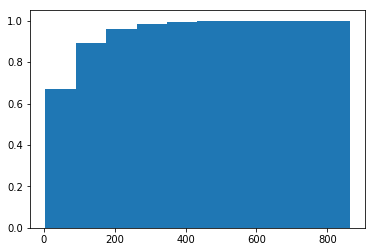

In [142]:
plt.hist(lens,cumulative=True,density=True)

In [64]:
tmp = len(sql_tok)
sql_tok = [i for i in sql_tok if len(i)>=4 and len(i)< int(lens.mean()+ 2*lens.std())] # Roughly 95% data
print('Filter out ', tmp - len(sql_tok), "sentences")

Filter out  1239 sentences


In [65]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common()] ## Avoid rare tokens
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([0] + [stoi[o] for o in p] + [2]) for p in tok]) # pad bos at beginning and eos at the end
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [66]:
sql_ids,sql_itos,sql_stoi = toks2ids(sql_tok,'sql')

In [67]:
sql_ids_concat= []
for i in sql_ids:
    sql_ids_concat += i

In [68]:
len(sql_itos)

16288

In [69]:
sql_ids.shape

(23355,)

In [70]:
vocab_size = len(sql_itos)
print('total words:', vocab_size)

total words: 16288


### Create inputs

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

In [180]:
idx = sql_ids_concat

In [181]:
char_indices = sql_stoi
indices_char = sql_itos

### Create and train model

Pick a size for our hidden state

## Multi-output model

### GRU

In [34]:
import pdb

In [182]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [46]:
# Tune Embedding size

In [49]:
n_hidden = 32

In [50]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [51]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      5.093435   4.78217   
    1      4.329296   3.750399                              
    2      3.883863   3.331731                              
    3      3.735478   3.2142                                
    4      3.686383   3.186601                              



[array([3.1866])]

In [52]:
n_hidden = 64

In [53]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [54]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      5.114829   5.020234  
    1      5.061008   4.840818                              
    2      3.690798   3.180483                              
    3      3.431884   3.00008                               
    4      3.348582   2.965333                              



[array([2.96533])]

In [55]:
n_hidden = 128

In [56]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [57]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.911029   3.290907  
    1      3.139146   2.787268                              
    2      2.992146   2.66855                               
    3      2.884279   2.598069                              
    4      2.824747   2.573492                              



[array([2.57349])]

In [69]:
n_hidden = 256

In [70]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [71]:
learn.fit(1e-2, 1, cycle_len=10, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      5.046133   4.954891  
    1      4.893719   4.724728                              
    2      3.161143   2.800292                              
    3      2.970051   2.680501                              
    4      2.928194   2.66087                               
    5      2.863552   2.614521                              
    6      2.797456   2.575808                              
    7      2.74659    2.539472                              
    8      2.693632   2.51797                               
    9      2.660389   2.510145                              



[array([2.51015])]

In [64]:
n_hidden = 512

In [65]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [66]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.249852   3.79147   
    1      3.072682   2.788784                              
    2      2.982907   2.686018                              
    3      2.840965   2.594483                              
    4      2.721307   2.547533                              



[array([2.54753])]

In [67]:
learn.fit(1e-3, 1, cycle_len=3, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.723165   2.551734  
    1      2.700525   2.536083                              
    2      2.66955    2.528203                              



[array([2.5282])]

In [68]:
learn.fit(1e-3, 1, cycle_len=3, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.681399   2.533979  
    1      2.674699   2.519563                              
    2      2.653546   2.512279                              



[array([2.51228])]

In [73]:
n_hidden=256
n_fac=300

In [74]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [75]:
learn.fit(1e-2, 1, cycle_len=10, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.110964   2.774432  
    1      2.815899   2.556583                              
    2      2.778743   2.542035                              
    3      2.810705   2.562714                              
    4      2.824984   2.583076                              
    5      2.77605    2.548158                              
    6      2.722447   2.510649                              
  2%|▏         | 7/336 [00:00<00:38,  8.49it/s, loss=2.72]

KeyboardInterrupt: 

In [76]:
n_hidden=256
n_fac=32

In [77]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [78]:
for i in range(1):learn.fit(1e-2, 1, cycle_len=10, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  8%|▊         | 27/336 [00:03<00:35,  8.80it/s, loss=7.75]

Exception in thread Thread-68:
Traceback (most recent call last):
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      5.073514   5.046971  
    1      5.09312    5.064133                              
    2      5.152407   5.115567                              
    3      4.086338   3.483777                              
    4      3.448298   3.06962                               
    5      3.292298   2.928553                              
 15%|█▍        | 50/336 [00:05<00:31,  9.08it/s, loss=3.25]


KeyboardInterrupt: 

In [80]:
n_hidden=256
n_fac=128

In [81]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [82]:
learn.fit(1e-2, 1, cycle_len=10, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.493544   4.145198  
    1      3.198818   2.813636                              
    2      2.886131   2.631072                              
    3      2.865718   2.611532                              
    4      2.87041    2.613879                              
    5      2.814938   2.569266                              
    6      2.758214   2.534505                              
    7      2.697882   2.502281                              
    8      2.655186   2.478388                              
    9      2.622147   2.469918                              



[array([2.46992])]

# Tuning n_hidden and Dropout

In [49]:
## One GRU

In [ ]:
n_hidden=256
n_fac=128
dropout=0
bidir=True

In [52]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, dropout=dropout, bidirectional=bidir)
        self.rnn2 = nn.GRU(n_hidden, n_hidden//2,dropout=dropout, bidirectional=bidir)
        self.l_out = nn.Linear(n_hidden +n_hidden *bidir, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
#         outp = self.rnn_drop1(outp)
#         self.h1 = repackage_var(h1)
#         outp,h2 = self.rnn2(outp,self.h2)        
#         self.h2 = repackage_var(h2)
#         outp = self.rnn_drop2(outp)
        
#         pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(1+1*bidir, bs, n_hidden))
        self.h2 = V(torch.zeros(1+1*bidir, bs, n_hidden//2))

In [53]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.489589   2.38543   
    1      2.199172   2.227707                              
    2      2.050445   2.14952                               
    3      1.871355   2.092305                              
    4      1.731721   2.063984                              



[array([2.06398])]

In [54]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, dropout=dropout, bidirectional=bidir)
        self.rnn2 = nn.GRU(n_hidden, n_hidden//2,dropout=dropout, bidirectional=bidir)
        self.l_out = nn.Linear(n_hidden +n_hidden *bidir, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
#         outp = self.rnn_drop1(outp)
        self.h1 = repackage_var(h1)
#         outp,h2 = self.rnn2(outp,self.h2)        
#         self.h2 = repackage_var(h2)
#         outp = self.rnn_drop2(outp)
        
#         pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(1+1*bidir, bs, n_hidden))
        self.h2 = V(torch.zeros(1+1*bidir, bs, n_hidden//2))

In [55]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.696434   2.633363  
    1      2.434904   2.456283                              
    2      2.320939   2.371596                              
    3      2.156249   2.277371                              
    4      2.033584   2.226436                              



[array([2.22644])]

In [56]:
bidir

False

In [57]:
bidir=True

In [58]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.970974   0.887447  
    1      0.751031   0.795377                               
    2      0.673117   0.761839                               
    3      0.520744   0.675822                               
    4      0.429682   0.63126                                



[array([0.63126])]

# Two GRU

In [36]:
n_hidden=256
n_fac=128
dropout=0
bidir=True

In [72]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, dropout=dropout, bidirectional=bidir)
        self.rnn2 = nn.GRU(n_hidden+n_hidden*bidir, n_hidden//2,dropout=dropout, bidirectional=bidir)
        self.l_out = nn.Linear(n_hidden//2 +n_hidden//2 *bidir, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
#         outp = self.rnn_drop1(outp)
        self.h1 = repackage_var(h1)
        outp,h2 = self.rnn2(outp,self.h2)        
        self.h2 = repackage_var(h2)
#         outp = self.rnn_drop2(outp)
        
#         pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(1+1*bidir, bs, n_hidden))
        self.h2 = V(torch.zeros(1+1*bidir, bs, n_hidden//2))

* cs is the input , cs = 5 for sequence Length, a tuple with length(cs)
* each tensor is 512, length = bs # batch size
* `(Pdb) torch.stack(cs).size()`
* `torch.Size([5, 512])`
* `(Pdb) outp.size()
torch.Size([5, 512, 256])`
*`(Pdb) !h.size()
torch.Size([1, 512, 256])`
*(Pdb) self.l_out(outp).size()
torch.Size([5, 512, 23125])
*(Pdb) self.l_out
Linear(in_features=256, out_features=23125, bias=True)



In [69]:
# m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))

In [47]:
bidir=False

m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.223879   4.033411  
    1      3.45677    3.446538                              
    2      2.852295   2.885229                              
    3      2.646157   2.679946                              
    4      2.526666   2.601328                              



[array([2.60133])]

In [ ]:
bidir=True
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [40]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 255/336 [01:02<00:19,  4.06it/s, loss=7.37]

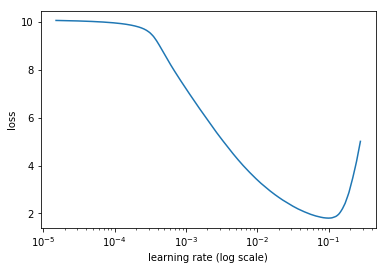

In [41]:
learn.sched.plot()

In [42]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  6%|▌         | 19/336 [00:04<01:18,  4.06it/s, loss=7.88]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                               
    0      0.676998   0.592733  
    1      0.459069   0.505907                               
    2      0.360548   0.485807                               
    3      0.273075   0.462775                               
    4      0.206725   0.455057                               



[array([0.45506])]

In [73]:
for n_hidden in [128,512]:
    for n_fac in [128, 64]:
        for bidir in [True,False]:
            
            n_hidden=n_hidden
            n_fac=n_fac
            dropout=0
            bidir=bidir
            
            print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
            m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
            opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
            learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
            learn.crit = nll_loss_seq
            learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

n_hidden: 128 n_fac: 128 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.212807   1.061725  
    1      0.811962   0.807159                               
    2      0.692939   0.731224                               
    3      0.583302   0.661865                               
    4      0.499812   0.634054                               

n_hidden: 128 n_fac: 128 bidir: False dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.914288   3.494619  
    1      2.612266   2.571698                              
    2      2.404728   2.423571                              
    3      2.288312   2.357915                              
    4      2.205917   2.330063                              

n_hidden: 128 n_fac: 64 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.37563    1.16036   
    1      0.826897   0.819891                               
    2      0.688435   0.725081                               
    3      0.572272   0.655405                               
    4      0.4963     0.626612                               

n_hidden: 128 n_fac: 64 bidir: False dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      5.027729   5.030593  
    1      5.048708   5.058978                              
    2      2.763283   2.670255                              
    3      2.46067    2.489534                              
    4      2.373273   2.449852                              

n_hidden: 512 n_fac: 128 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.94612    0.843543  
    1      0.767407   0.819792                               
    2      0.747876   0.809661                               
    3      0.573085   0.689847                               
    4      0.45382    0.632427                               

n_hidden: 512 n_fac: 128 bidir: False dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.340119   4.249814  
    1      2.817755   2.827256                              
    2      2.617266   2.633138                              
    3      2.40641    2.457128                              
    4      2.257149   2.374019                              

n_hidden: 512 n_fac: 64 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.369762   1.327064  
    1      0.900154   0.905763                               
    2      0.80147    0.835397                               
    3      0.60252    0.705347                               
    4      0.469994   0.644672                               

n_hidden: 512 n_fac: 64 bidir: False dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.825634   4.738349  
    1      3.687249   3.74783                               
    2      3.420143   3.443927                              
    3      3.188692   3.194999                              
    4      3.013855   3.066492                              



## Change CS length

Bidir is clearly important, and it make sense as table schema comes after column name.
Set Bidir to true and test longer cs=16, and test differe n_hidden and n_fac


In [183]:
cs=16

c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)]

c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

xs = np.stack(c_in_dat)
xs.shape

ys = np.stack(c_out_dat)
ys.shape

(106568, 16)

In [184]:
xs.shape,ys.shape

((106568, 16), (106568, 16))

In [185]:
bs=256

In [186]:
val_idx = get_cv_idxs(len(xs)-cs-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=bs)

In [187]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, dropout=dropout, bidirectional=bidir)
        self.rnn2 = nn.GRU(n_hidden+n_hidden*bidir, n_hidden//2,dropout=dropout, bidirectional=bidir)
        self.l_out = nn.Linear(n_hidden//2 +n_hidden//2 *bidir, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
#         outp = self.rnn_drop1(outp)
        self.h1 = repackage_var(h1)
        outp,h2 = self.rnn2(outp,self.h2)        
        self.h2 = repackage_var(h2)
#         outp = self.rnn_drop2(outp)
        
#         pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(1+1*bidir, bs, n_hidden))
        self.h2 = V(torch.zeros(1+1*bidir, bs, n_hidden//2))

In [25]:
n_hidden =128
n_fac=64
dropout=0
bidir=True

In [28]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

n_hidden: 128 n_fac: 64 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.739399   0.63312   
    1      0.409324   0.412669                               
    2      0.311626   0.355719                               
    3      0.228066   0.316156                               
    4      0.178496   0.298951                               



[array([0.29895])]

In [29]:
n_hidden =64
n_fac=64
dropout=0
bidir=True

In [30]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

n_hidden: 64 n_fac: 64 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.234964   0.967665  
    1      0.550799   0.543247                               
    2      0.40817    0.444744                               
    3      0.33237    0.403327                               
    4      0.282332   0.387894                               



[array([0.38789])]

In [31]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▉   | 291/420 [00:22<00:10, 12.68it/s, loss=1.11] 

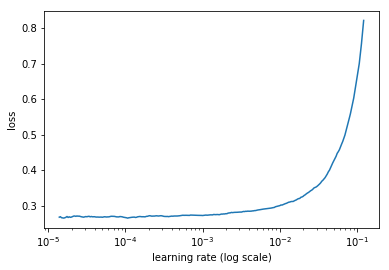

 69%|██████▉   | 291/420 [00:40<00:17,  7.27it/s, loss=1.11]

In [32]:
learn.sched.plot()

In [33]:
n_hidden =96
n_fac=48
dropout=0
bidir=True

In [34]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

n_hidden: 96 n_fac: 48 bidir: True dropout: 0


In [35]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  5%|▍         | 20/420 [00:02<00:43,  9.10it/s, loss=10.1]

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 76%|███████▌  | 320/420 [00:32<00:10,  9.90it/s, loss=8.69]


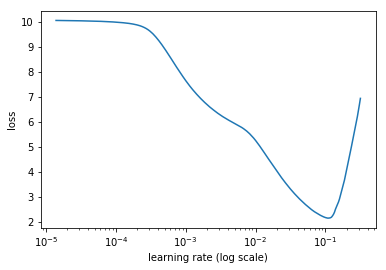

 76%|███████▌  | 320/420 [00:42<00:13,  7.60it/s, loss=8.69]

In [36]:
learn.sched.plot()

In [37]:
learn.fit(5e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.10403    1.065086  
    1      1.002034   1.0852                                 
    2      1.414777   1.334097                              
    3      0.905716   0.921388                               
    4      0.660897   0.779194                               



[array([0.77919])]

In [39]:
learn.fit(1e-3, 1, cycle_len=3,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.615019   0.765011  
    1      0.59362    0.747414                               
    2      0.577564   0.742213                               



[array([0.74221])]

In [40]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████   | 299/420 [00:30<00:12,  9.90it/s, loss=2.38] 

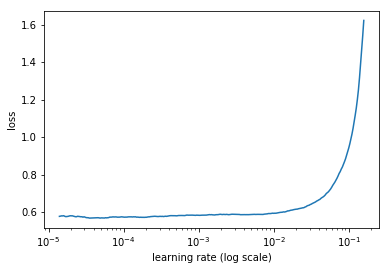

 71%|███████   | 299/420 [00:40<00:16,  7.47it/s, loss=2.38]

In [41]:
learn.sched.plot()

In [42]:
learn.fit(1e-2, 1, cycle_len=1,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 18%|█▊        | 77/420 [00:07<00:35,  9.75it/s, loss=0.624]

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                               
    0      0.62796    0.718903  



[array([0.7189])]

## GridSearch

In [188]:
for n_hidden in [128]:
    for n_fac in [64]:
        for bidir in [True]:
            for dropout in [0.5]:
            
                n_hidden=n_hidden
                n_fac=n_fac
                dropout=dropout
                bidir=bidir

                print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)

                m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
                opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
                learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
                learn.crit = nll_loss_seq
                learn.fit(1e-3, 1, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

n_hidden: 128 n_fac: 64 bidir: True dropout: 0.5


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.031967   1.834755  



In [189]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)
    i = np.argmax(p[-1,:,:])
    
    return indices_char[i]

In [190]:
inp ="select userid from users where ".split()

In [191]:
idxs = T(np.array([char_indices[c] for c in inp]))
p = m(*VV(idxs))
p = to_np(p)

In [192]:
" ".join([sql_itos[i] for i in sql_ids[0]])

"_bos_ select Id from Comments where lower ( Text ) like ' % accept % answer % ' order by len ( Text ) asc _eos_"

In [193]:
idxs = T(np.array([char_indices[c] for c in inp]))

In [194]:
inp

['select', 'userid', 'from', 'users', 'where']

In [195]:
[sql_itos[i] for i in idxs]

['select', 'userid', 'from', 'users', 'where']

In [196]:
get_next("_eos_".split())

'_bos_'

In [197]:
get_next("_bos_ select".split())

'_eos_'

In [198]:
get_next("_bos_ select top".split())

'100'

In [199]:
get_next('select * from ')

')'

In [200]:
learn.fit(1e-3, 1, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.894358   0.850054  



[array([0.85005])]

In [201]:
get_next("_bos_ select".split())

'top'

In [202]:
get_next("_bos_ select top".split())

'('

In [203]:
learn.fit(5e-3, 1, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.424045   0.40766   



[array([0.40766])]

In [204]:
get_next("_bos_ select".split())

'top'

In [205]:
get_next("_bos_ select top".split())

'#'

In [206]:
get_next("_bos_ select top 100 p . id as [ post link ]".split())

','

# Make More sense now

In [207]:
learn.fit(5e-3, 1, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.324575   0.327948  



[array([0.32795])]

In [208]:
dropout

0.5

In [102]:
learn.fit(5e-3, 1, cycle_len=3, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.351886   0.375967  
    1      0.283442   0.329145                               
    2      0.219451   0.305896                               



[array([0.3059])]

In [113]:
'_bos_'.split()

['_bos_']

In [209]:
get_next('_bos_ select top '.split())

'1'

In [212]:
get_sentence('_bos_ select'.split())

['_bos_',
 'select',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.'

In [116]:
??get_sentence

In [213]:
get_sentence(['_bos_', 'select'])

['_bos_',
 'select',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.',
 '_unk',
 '_unk',
 '.',
 '[',
 '_unk',
 ']',
 ',',
 '_unk',
 '.'

In [46]:
p.shape

(5, 1, 16286)

In [50]:
i[0][:10]

array([48])

In [31]:
    i = np.argmax(p[-1,:,:])

In [28]:
learn.fit(1e-3, 1, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.895093   0.861857  



[array([0.86186])]

In [29]:
get_sentence(['select'])

['select',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top',
 'top

In [76]:
get_sentence(['select'])

['select',
 'userid',
 'from',
 'badges',
 'select',
 "'",
 'distinct',
 "'",
 'select',
 '*',
 'from',
 'posts',
 'where',
 'posttypeid',
 '=',
 '1',
 'and',
 'posttypeid',
 '=',
 '1',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '1',
 'and',
 'p',
 '.',
 'score',
 '>',
 '=',
 '0',
 'and',
 'p',
 '.',
 'closeddate',
 'is',
 'null',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '1',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 'p',
 '.',
 'posttypeid',
 '=',
 '2',
 'and',
 '

In [74]:
get_next_random("select userid from users where ".split())

IndexError: index 435 is out of bounds for axis 0 with size 1

In [ ]:
for n_hidden in [128]:
    for n_fac in [64]:
        for bidir in [True]:
            for dropout in [0.8,0.5]:
            
                n_hidden=n_hidden
                n_fac=n_fac
                dropout=dropout
                bidir=bidir

                print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)

                m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
                opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
                learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
                learn.crit = nll_loss_seq
                learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

In [114]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/336 [00:00<?, ?it/s]


NameError: name 'fn' is not defined

In [91]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.263932   4.05082   
    1      2.676606   2.59086                               
    2      2.39388    2.413409                              
    3      2.249364   2.32088                               
    4      2.140876   2.275713                              



[array([2.27571])]

In [39]:
learn.save('tmp1')

In [40]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▍ | 284/336 [00:24<00:04, 11.56it/s, loss=13.5]

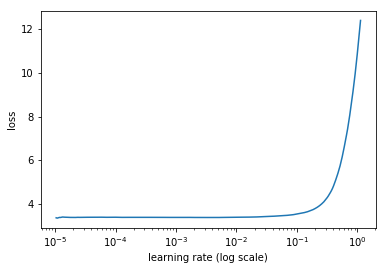

In [42]:
learn.sched.plot(1,1)

In [16]:
learn.fit(1e-3, 1, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

NameError: name 'learn' is not defined

In [44]:
learn.save('tmp2')

In [45]:
learn.fit(1e-4, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.36404    2.981094  
    1      3.366188   2.979906                              
    2      3.363372   2.977092                              
    3      3.361462   2.976001                              
    4      3.361196   2.975682                              



[array([2.97568])]

## Test Sentence

In [ ]:
def get_next_random_fsm(inp, fsm):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    pi = p.argsort()[-10:]
    i = np.random.choice(pi, p=softmax_np(p[pi]))
    
    if fsm.run(indices_char[i]):
        return indice_char[i]
    else: 
        for pii in pi:
            if fsm.run(indice_char[pii]):
                print('pii loop')
                return indice_char[pii]
            else:
                print('Error, no valid words at all')  
    
    
    return "ERROR"

fsm = Rule_Parse_FSM()

get_next_random("select userid from users where ".split())

get_next_random_fsm("select userid from users where ".split(), fsm)

In [ ]:
a=get_sentence(['select','*','from','where','users'])

b=get_sentence_random(['select','*','from','where','users'])

show_sentence(b)

show_sentence(a)

show_sentence(a)

get_next(['select', '*', 'from'])

In [8]:
def get_next_random(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    pi = p.argsort()[-10:]
    i = np.random.choice(pi, p=softmax_np(p[pi]))
    return indices_char[i]
def softmax_np (nparray):
    ans = np.exp(nparray)
    return ans/ans.sum()

def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    p = to_np(p)
    
    return indices_char[i]

def get_sentence(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next(sentence[-8:]) # always get last three
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence
        

def get_sentence_random(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next_random(sentence[-8:]) # always get last three
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence
        

def show_sentence(inp):
    sentence =''
    captialize = False
    for i in inp:
        if i =='t_up':
            captialize = True
        else:            
            if captialize:
                sentence = sentence + " " + i.upper()       
           
            else:
                sentence = sentence +" " + i
            captialize = False
    return sentence